## LSST Solar System Processing

## Linking of Simulated dataset with HelioLinC3D

### Algorithm: 

* Similar to HelioLinC (Holman et al. 2018) we transform topocentric observations to heliocentric states assuming a distance and radial velocity.
* The resulting 3D positions are collected into tracklets. Tracklets contain at least two observations and can, thus, be used to create velocity vectors.
* A tracklet + velocity vector is called an "arrow". 
* Arrows are propagated to a common epoch using spiceypy's 2body propagator, and then clustered using dbscan.
* We calculate a mean state and variance for each cluster (trimmed mean), which is our best guess for the underlying orbit (IOD)
* We can filter all clusters based on their variance

### Implementation:
S. Eggl 20210218
    

In [1]:
# HelioLinC3D Solar System Processing functions for LSST
import heliolinc2 as hl

In [2]:
# Demo relevant python modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
import spiceypy as sp

In [4]:
# Joblib prallelization
import joblib
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects
from joblib import Parallel, delayed

In [5]:
# Progress bar for joblib processes
import contextlib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback:
        def __init__(self, time, index, parallel):
            self.index = index
            self.parallel = parallel

        def __call__(self, index):
            tqdm_object.update()
            if self.parallel._original_iterator is not None:
                self.parallel.dispatch_next()

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()   

## KBMOD OBSERVATIONS 


### Select observations from LSST Survey Simulation Dataset

In [6]:
trailin0=pd.read_csv("Michigan_Data/FAKE_PG008_OBS.csv",',',skiprows=0,usecols=['OBSID','MJD','RA','DEC','RA_RATE','DEC_RATE','FAKEID'])
trailin1=pd.read_csv("Michigan_Data/FAKE_PG021_OBS.csv",',',skiprows=0,usecols=['OBSID','MJD','RA','DEC','RA_RATE','DEC_RATE','FAKEID'])
trailin2=pd.read_csv("Michigan_Data/FAKE_PG023_OBS.csv",',',skiprows=0,usecols=['OBSID','MJD','RA','DEC','RA_RATE','DEC_RATE','FAKEID'])


In [7]:
trailin0

,FAKEID,MJD,RA,DEC,RA_RATE,DEC_RATE,OBSID
0,1A0C7B779088,58724.299382,351.677066,-4.149026,-0.019954,-0.007647,faacf9a74f2e4fbdb7a8eeb31f13c072
1,715661567DCC,58724.299382,351.654417,-4.071322,-0.016176,-0.006530,2031c188934e461b87ac657743de8537
2,7BEB8D5C6BCC,58724.299382,351.689369,-4.138127,-0.015663,-0.006456,f7ed73b5b37541dea26eed79354332e2
3,865D79C8C8BE,58724.299382,351.542500,-4.182902,-0.016855,-0.007028,921ce261ef8e42b7b95e3d93cfc14a2f
4,8CD46B1C20DC,58724.299382,351.454822,-4.090292,-0.017603,-0.007078,0a759fba47e8418190080c6274e6492c
...,...,...,...,...,...,...,...
466,79F79C6C0F3F,58724.299382,352.324508,-5.929195,-0.015106,-0.006171,fc96a721d8234cdd921bd95cfdd56ba3
467,CC601CAC4375,58724.299382,352.274369,-5.903860,-0.015170,-0.006492,ac0527792a1d48779b69acd6d474954a
468,D0E9F0D9E9DF,58724.299382,352.070187,-5.945459,-0.015264,-0.006473,18ba180aa10f409a809eba80ee72776c
469,EE982E87925E,58724.299382,352.308827,-5.958423,-0.019826,-0.007743,fb1cb257a70a4e43a71feab9905fb8d2


In [8]:
# Reformat input
dftrails=pd.DataFrame()
dftrails=pd.concat([trailin0,trailin1,trailin2]).reset_index(drop=True)
coldict={'OBSID':'trailName','MJD':'time','RA':'RA_center','DEC':'DEC_center','RA_RATE':'RA_vel','DEC_RATE':'DEC_vel','FAKEID':'FAKEID'}
dftrails.rename(columns=coldict,inplace=True)
dftrails['night']=hl.utility.lsstNight(dftrails['time'],minexpMJD=dftrails['time'].min(),local_midnight=0.166)
dftrails.sort_values(['time'],inplace=True)
dftrails.reset_index(drop=True,inplace=True)
dftrails['trailId']=dftrails.index

In [9]:
dftrails

,FAKEID,time,RA_center,DEC_center,RA_vel,DEC_vel,trailName,night,trailId
0,1A0C7B779088,58724.299382,351.677066,-4.149026,-0.019954,-0.007647,faacf9a74f2e4fbdb7a8eeb31f13c072,0,0
1,2F1FE1D75940,58724.299382,351.675161,-5.350937,-0.014379,-0.006097,feed5d936b11469597302a779f4c35cf,0,1
2,03A3B00C7C3D,58724.299382,351.794196,-5.264066,-0.017591,-0.008449,65b86ace612c4ebfad2d087b4535dd5b,0,2
3,BB07D02177B1,58724.299382,351.419344,-5.285209,-0.026400,-0.010796,b7ee8d5c61ea4e90965c5d3af18f6046,0,3
4,B8B1031686F2,58724.299382,351.480028,-5.313585,-0.024304,-0.009596,c65b74d61ac94afb89d532bf778ff36e,0,4
...,...,...,...,...,...,...,...,...,...
1384,FBA875BB2D12,58755.182773,351.912682,-4.888237,-0.017285,-0.007264,955af58184d143048ff4cb42ee58a3e6,31,1384
1385,ED5E73A5506A,58755.182773,351.810615,-4.756688,-0.018556,-0.008157,98b7fc507e7b44c6b398e89f41094074,31,1385
1386,AA6A72551D4C,58755.182773,351.939649,-4.796497,-0.019166,-0.007751,02ab295998704aaf9c4523f9a9270e81,31,1386
1387,7A4FD6559262,58755.182773,351.846718,-4.782514,-0.019408,-0.007510,968e664ab1144dcb9062a3cffe3052f8,31,1387


In [10]:
dftrails['DEC_vel'] = dftrails['DEC_vel']/np.cos(np.deg2rad(dftrails['DEC_center']))

In [11]:
dftrails

,FAKEID,time,RA_center,DEC_center,RA_vel,DEC_vel,trailName,night,trailId
0,1A0C7B779088,58724.299382,351.677066,-4.149026,-0.019954,-0.007667,faacf9a74f2e4fbdb7a8eeb31f13c072,0,0
1,2F1FE1D75940,58724.299382,351.675161,-5.350937,-0.014379,-0.006124,feed5d936b11469597302a779f4c35cf,0,1
2,03A3B00C7C3D,58724.299382,351.794196,-5.264066,-0.017591,-0.008485,65b86ace612c4ebfad2d087b4535dd5b,0,2
3,BB07D02177B1,58724.299382,351.419344,-5.285209,-0.026400,-0.010842,b7ee8d5c61ea4e90965c5d3af18f6046,0,3
4,B8B1031686F2,58724.299382,351.480028,-5.313585,-0.024304,-0.009638,c65b74d61ac94afb89d532bf778ff36e,0,4
...,...,...,...,...,...,...,...,...,...
1384,FBA875BB2D12,58755.182773,351.912682,-4.888237,-0.017285,-0.007290,955af58184d143048ff4cb42ee58a3e6,31,1384
1385,ED5E73A5506A,58755.182773,351.810615,-4.756688,-0.018556,-0.008185,98b7fc507e7b44c6b398e89f41094074,31,1385
1386,AA6A72551D4C,58755.182773,351.939649,-4.796497,-0.019166,-0.007778,02ab295998704aaf9c4523f9a9270e81,31,1386
1387,7A4FD6559262,58755.182773,351.846718,-4.782514,-0.019408,-0.007536,968e664ab1144dcb9062a3cffe3052f8,31,1387


## Run HelioLinC3D

### Choose HelioLinC3D clustering parameters

In [12]:
# Clustering radius for heliocentric positions projected from observations [au]
cr_obs=0.02
# Clustering radius for propagated arrows [au]
cr_arrows=2
# max temporal separation for tracklet observations (days)
ct_max=20/24
# min temporal separation for tracklet observations, e.g. exposure time (days)
ct_min=25/86400 
# Minimum number of arrows to be clustered ('DBSCAN only')
min_samples=3

In [13]:
helres=hl.heliolinc2(50, 0.00, cr_obs, cr_arrows, ct_min, ct_max, 
                     dfobs=pd.DataFrame(), dftrails=dftrails, observer_location='807',
                     ephemeris_dt='22h',trail_dt=0.1, min_samples=min_samples, v_max=1,
                     light_time=True, clustering_dimensions=6, 
                     verbose=False, n_jobs=1, mean_state_variance_limit=5e-1) 

/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])


In [14]:
helres

,clusterId,obsId,trailId,r,drdt,cluster_epoch,x_ecl,y_ecl,z_ecl,vx_ecl,vy_ecl,vz_ecl,var_pos,var_vel
0,-1,-1,"[203, 347, 441, 646, 850, 975, 1007, 1058, 110...",50,0.0,58739.741077,49.284272,-8.322626,-1.139086,0.000003,-0.000018,1.561775e-04,2.324359e-01,2.047106e-07
1,0,-1,"[0, 3, 4, 5, 10, 11, 14, 16, 18, 19, 20, 22, 2...",50,0.0,58739.741077,49.273510,-8.393379,-1.174882,-0.000423,-0.002475,-7.261854e-07,2.622568e-01,3.962980e-06
2,1,-1,"[1, 6, 7, 8, 12, 13, 15, 17, 21, 25, 27, 28, 3...",50,0.0,58739.741077,49.270697,-8.410646,-1.195429,0.000365,0.002142,-7.242063e-06,2.645357e-01,1.109794e-06
3,2,-1,"[2, 39, 136, 139, 157, 239, 282, 316, 357, 358...",50,0.0,58739.741077,49.278040,-8.375284,-0.971494,0.000002,0.000104,-6.653303e-04,2.324200e-01,1.004336e-07
4,3,-1,"[9, 274, 428, 488, 746, 933]",50,0.0,58739.741077,49.190703,-8.892223,-0.973089,0.000084,0.000526,-5.963436e-04,8.690200e-02,3.246732e-08
5,4,-1,"[34, 109, 138, 266, 294, 510, 528, 640, 652, 7...",50,0.0,58739.741077,49.279346,-8.330782,-1.205703,-0.000076,-0.000567,6.232774e-04,2.495432e-01,3.187637e-07
6,5,-1,"[54, 334, 409, 475, 816, 908, 1185]",50,0.0,58739.741077,49.258395,-8.510769,-0.991623,-0.000050,-0.000242,-4.555019e-04,1.122294e-01,1.861815e-08
7,6,-1,"[70, 147, 185, 195, 198, 242, 445, 597, 655, 6...",50,0.0,58739.741077,49.238684,-8.554641,-1.344088,0.000167,0.001054,-6.876110e-04,1.382616e-01,2.405475e-08
8,7,-1,"[90, 276, 366, 397, 400, 561, 682, 708, 747, 8...",50,0.0,58739.741077,49.307888,-8.204628,-1.082615,0.000008,-0.000038,6.972214e-04,2.668165e-01,3.203593e-08
9,8,-1,"[113, 243, 271, 291, 353, 362, 427, 556, 654, ...",50,0.0,58739.741077,49.277562,-8.397814,-0.943152,0.000099,0.000486,6.359675e-04,2.405464e-01,1.785754e-07


### Choose heliocentric distance and velocity grid

In [15]:
# define range of heliocentric distances
rall=np.arange(30,60,0.5)
# define range of heliocentric radial velocities
drdtall=np.arange(-0.01,0.01,0.0005)
np.append(drdtall,0.0)

# Iterator for joblib based paralellization
rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

# How many configuraitons do we have to run?
print(len(rrdot))

2400


In [16]:
# Parallelize over a grid of initial conditions

n_cores=10

with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          ( r, drdt, cr_obs, cr_arrows, ct_min, ct_max, dfobs=pd.DataFrame(), dftrails=dftrails,
                                           ephemeris_dt='22h',observer_location='807', origin='SSB',clustering_dimensions=6,
                                             trail_dt=1, min_samples=min_samples, v_max=1,
                                             light_time=True, 
                                             verbose=False, n_jobs=1, mean_state_variance_limit=1e-1) 
                                           for r, drdt in rrdot ) 

HelioLinC2: 100%|██████████| 2400/2400 [00:29<00:00, 82.14it/s]


In [17]:
clusters_df

[   clusterId  obsId                                            trailId     r  \
 0          0     -1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  30.0   
 1          1     -1                                   [420, 910, 1332]  30.0   
 
    drdt  cluster_epoch      x_ecl     y_ecl     z_ecl    vx_ecl    vy_ecl  \
 0 -0.01   58739.741077  29.561975 -5.048615 -0.691391 -0.008682  0.008468   
 1 -0.01   58739.741077  29.578117 -4.978809 -0.555809 -0.009895  0.001293   
 
      vz_ecl   var_pos       var_vel  
 0  0.000233  0.091355  2.474214e-06  
 1  0.000220  0.000004  3.290353e-08  ,
    clusterId  obsId                                            trailId     r  \
 0          0     -1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  30.0   
 1          1     -1                                   [420, 910, 1332]  30.0   
 
      drdt  cluster_epoch      x_ecl     y_ecl     z_ecl    vx_ecl    vy_ecl  \
 0 -0.0095   58739.741077  29.562027 -5.048586 -0.691392 -0.008191  0.008383

In [18]:
# each set of initial conditions produces a data frame with linkages; we merge all of them and give them a unique index
clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
clustered_observations['clusterId']=clustered_observations.index

In [19]:
# remove duplicate clusters
clustered_observations['clusterObs'] = clustered_observations['trailId'].astype(str) 
clustered_observations.sort_values(by=['clusterObs','var_pos','var_vel'],inplace=True)
clustered_observations.drop_duplicates(subset='clusterObs',keep="first",ignore_index=True, inplace=True)
dedupe=clustered_observations.drop(columns=['clusterObs'])

In [20]:
# apply mean state filter
filtered=dedupe[dedupe['var_pos']<1e-3]

In [21]:
# number of filtered clusters (number of objects found)
len(filtered)

267

In [22]:
filtered

,clusterId,obsId,trailId,r,drdt,cluster_epoch,x_ecl,y_ecl,z_ecl,vx_ecl,vy_ecl,vz_ecl,var_pos,var_vel
3,26488,-1,"[0, 781, 1240]",51.0,-0.0015,58739.741077,50.280742,-8.523660,-0.438153,-0.001827,-0.001848,0.000736,0.000004,1.308966e-10
13,9232,-1,"[3, 503, 1120]",42.0,0.0060,58739.741077,41.297558,-7.578590,-1.038001,0.005220,-0.004839,0.000277,0.000001,6.004338e-09
22,16212,-1,"[4, 667, 1121]",46.0,0.0030,58739.741077,45.241156,-8.237780,-1.174808,0.002261,-0.004409,0.000603,0.000001,2.451363e-09
25,48507,-1,"[5, 500, 1122]",59.0,0.0045,58739.741077,58.011768,-10.656324,-1.443039,0.003470,-0.005891,-0.000928,0.000001,2.342269e-09
29,49594,-1,"[1, 471, 954]",59.5,0.0020,58739.741077,58.573860,-10.326176,-1.650189,0.002078,0.000252,0.000064,0.000006,9.450890e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,49523,-1,"[106, 572, 983]",59.5,0.0015,58739.741077,58.655214,-9.850433,-1.668770,0.001379,-0.000910,0.000348,0.000005,6.094047e-10
716,29073,-1,"[108, 518, 965]",52.0,-0.0010,58739.741077,51.274066,-8.525501,-1.511463,-0.001343,-0.001937,-0.000252,0.000002,1.048809e-09
717,28981,-1,"[115, 566, 947]",52.0,-0.0015,58739.741077,51.309166,-8.316059,-1.486566,-0.001687,-0.001139,0.000575,0.000003,4.173973e-10
725,49885,-1,"[234, 698, 982]",59.5,0.0050,58739.741077,58.746618,-9.300225,-1.609048,0.004976,-0.000510,-0.000304,0.000006,4.047407e-09


In [23]:
# check for purity in linkages
for index, row in filtered.iterrows():
        tid = list(row.trailId)
        print(dftrails[dftrails['trailId'].isin(tid)]['FAKEID'])

0       1A0C7B779088
781     1A0C7B779088
1240    1A0C7B779088
Name: FAKEID, dtype: object
3       BB07D02177B1
503     BB07D02177B1
1120    BB07D02177B1
Name: FAKEID, dtype: object
4       B8B1031686F2
667     B8B1031686F2
1121    B8B1031686F2
Name: FAKEID, dtype: object
5       A1F7353FF222
500     A1F7353FF222
1122    A1F7353FF222
Name: FAKEID, dtype: object
1      2F1FE1D75940
471    2F1FE1D75940
954    2F1FE1D75940
Name: FAKEID, dtype: object
10      41E271F1ACC9
551     41E271F1ACC9
1141    41E271F1ACC9
Name: FAKEID, dtype: object
2      03A3B00C7C3D
481    03A3B00C7C3D
980    03A3B00C7C3D
Name: FAKEID, dtype: object
31      521F40E01FD7
507     521F40E01FD7
1041    521F40E01FD7
Name: FAKEID, dtype: object
33      E45DDC59FED2
509     E45DDC59FED2
1008    E45DDC59FED2
Name: FAKEID, dtype: object
36      A12CC7B829E0
697     A12CC7B829E0
1146    A12CC7B829E0
Name: FAKEID, dtype: object
45      D8F0FB15EA13
582     D8F0FB15EA13
1024    D8F0FB15EA13
Name: FAKEID, dtype: object
48   

55     CE96AAC01F33
476    CE96AAC01F33
976    CE96AAC01F33
Name: FAKEID, dtype: object
66     97763B7339A2
542    97763B7339A2
984    97763B7339A2
Name: FAKEID, dtype: object
71     DAB3CA7299EA
545    DAB3CA7299EA
989    DAB3CA7299EA
Name: FAKEID, dtype: object
73     E8E19507C635
549    E8E19507C635
993    E8E19507C635
Name: FAKEID, dtype: object
75     A700C0523C47
550    A700C0523C47
995    A700C0523C47
Name: FAKEID, dtype: object
76     99FA4311B1F2
552    99FA4311B1F2
996    99FA4311B1F2
Name: FAKEID, dtype: object
837     311733B08421
998     7A84D6C51430
1285    311733B08421
Name: FAKEID, dtype: object
90     3AE41259F486
561    3AE41259F486
949    3AE41259F486
Name: FAKEID, dtype: object
93     12B7E585660F
569    12B7E585660F
955    12B7E585660F
Name: FAKEID, dtype: object
95     E99DCD9022D6
573    E99DCD9022D6
963    E99DCD9022D6
Name: FAKEID, dtype: object
96     E008C7EECC5D
517    E008C7EECC5D
964    E008C7EECC5D
Name: FAKEID, dtype: object
100    8C1B6E509B4A
565    8C

In [24]:
# how many unique objects are in the input data frame?
print(len(dftrails['FAKEID'].unique()))

573


In [25]:
# how many objects actually appear at least three times at different epochs in the input data set? 
grp=dftrails.groupby(['FAKEID'])
obs=grp.count()
idx=np.where(obs['time'] >= 3)[0]
print(len(idx))

321


In [26]:
dftrails

,FAKEID,time,RA_center,DEC_center,RA_vel,DEC_vel,trailName,night,trailId
0,1A0C7B779088,58724.299382,351.677066,-4.149026,-0.019954,-0.007667,faacf9a74f2e4fbdb7a8eeb31f13c072,0,0
1,2F1FE1D75940,58724.299382,351.675161,-5.350937,-0.014379,-0.006124,feed5d936b11469597302a779f4c35cf,0,1
2,03A3B00C7C3D,58724.299382,351.794196,-5.264066,-0.017591,-0.008485,65b86ace612c4ebfad2d087b4535dd5b,0,2
3,BB07D02177B1,58724.299382,351.419344,-5.285209,-0.026400,-0.010842,b7ee8d5c61ea4e90965c5d3af18f6046,0,3
4,B8B1031686F2,58724.299382,351.480028,-5.313585,-0.024304,-0.009638,c65b74d61ac94afb89d532bf778ff36e,0,4
...,...,...,...,...,...,...,...,...,...
1384,FBA875BB2D12,58755.182773,351.912682,-4.888237,-0.017285,-0.007290,955af58184d143048ff4cb42ee58a3e6,31,1384
1385,ED5E73A5506A,58755.182773,351.810615,-4.756688,-0.018556,-0.008185,98b7fc507e7b44c6b398e89f41094074,31,1385
1386,AA6A72551D4C,58755.182773,351.939649,-4.796497,-0.019166,-0.007778,02ab295998704aaf9c4523f9a9270e81,31,1386
1387,7A4FD6559262,58755.182773,351.846718,-4.782514,-0.019408,-0.007536,968e664ab1144dcb9062a3cffe3052f8,31,1387


In [27]:
discoverable=dftrails.iloc[idx]

In [28]:
ele = []
for index,row in filtered.iterrows():
    state = np.array(row[['x_ecl','y_ecl','z_ecl','vx_ecl','vy_ecl','vz_ecl']].astype(float))
    ele.append(sp.oscltx(state,0,0.0172**2))

In [29]:
eledf=pd.DataFrame(ele, columns=['q','e','i','node','w','M','t0','mu','true_anomaly','a','P']).drop(index=1)

In [30]:
eledf

,q,e,i,node,w,M,t0,mu,true_anomaly,a,P
0,27.830234,0.594974,2.813805,6.089992,1.763757,5.696721,0.0,0.000296,4.492740,68.712158,208066.328992
2,33.752712,2.375642,2.968543,5.956392,5.234404,0.981482,0.0,0.000296,0.899910,-24.535979,0.000000
3,43.092764,6.473435,2.982608,3.113112,2.485652,4.728324,0.0,0.000296,0.811052,-7.873076,0.000000
4,2.355562,0.955735,0.195893,6.248962,3.262814,0.746273,0.0,0.000296,2.877397,53.215244,141809.557828
5,52.321988,6.397301,2.852644,3.046753,3.597342,-1.755328,0.0,0.000296,5.917243,-9.694102,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
262,3.762692,0.909777,2.613446,6.068691,3.345784,1.255485,0.0,0.000296,2.881717,41.704339,98383.730373
263,29.707439,0.421731,3.007436,3.193982,5.392887,5.105002,0.0,0.000296,4.250952,51.373038,134509.914387
264,11.806077,0.724471,2.775909,6.047745,2.487846,5.105422,0.0,0.000296,3.715308,42.848723,102460.919538
265,0.609894,1.031264,0.553203,2.940762,0.370669,1.872064,0.0,0.000296,2.822416,-19.508013,0.000000


In [31]:
fake_ele_df=pd.read_csv('Michigan_Data/B1_fake_elements.csv')

In [32]:
fake_ele_df

,A,E,I,FAKEID,H,G,AOP,LAN,M,T0,...,VX,VY,VZ,EPOCH,T_PERI,R,VARPI,PHI0,DELTA_H,ROT_PERIOD
0,45.107449,0.466578,4.012202,B55800EAE098,7.617815,0.15,237.710021,339.437262,86.744853,NaN,...,0.001189,0.001791,0.000147,2458849.5,2432204.1844848683,NaN,217.147283,34.110802,0.081484,0.424032
1,68.176423,0.337078,2.270638,EDE677C69A6A,9.985279,0.15,20.788825,352.610386,350.384282,NaN,...,0.000096,0.002922,0.000115,2458849.5,2258863.001367966,NaN,13.399211,355.956438,0.242142,0.898042
2,49.477169,0.263554,1.707669,497A9FA4D015,10.808537,0.15,201.362378,161.508158,354.156013,NaN,...,0.000297,0.003182,-0.000093,2458849.5,2333879.2518343823,NaN,2.870536,228.699169,0.206737,0.953664
3,31.000505,0.307182,17.137777,CF80A19E9AD8,9.646841,0.15,292.399935,165.715745,289.717941,NaN,...,-0.000582,0.002956,-0.000839,2458849.5,2408146.5440014754,NaN,98.115680,292.727034,0.081547,0.352763
4,38.039446,0.133216,3.702850,FBC2FDF184A2,10.717523,0.15,315.171701,94.019705,315.030900,NaN,...,0.000103,0.003034,-0.000020,2458849.5,2383910.2796767787,NaN,49.191407,75.494038,0.022820,0.597501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5126,154.617938,0.391141,10.486960,BCAEAACFE1A4,2.038640,0.15,149.873523,356.375026,228.927546,NaN,...,-0.000077,0.000977,0.000180,2458849.5,2012584.718936317,NaN,146.248549,278.470547,0.000000,332.230121
5127,219.153624,0.418556,13.516854,3B111E15C86B,4.706636,0.15,233.337505,162.980288,341.775884,NaN,...,-0.000117,0.001652,-0.000372,2458849.5,1334583.32379261,NaN,36.317793,130.683975,0.000000,936.054300
5128,234.163270,0.520970,5.115944,E66253C4D3D6,3.310968,0.15,271.047061,2.294031,25.305656,NaN,...,0.000934,0.001329,0.000116,2458849.5,2366910.345718135,NaN,273.341092,348.549582,0.000000,590.585018
5129,555.725198,0.596591,5.867915,56D3BFAFCAC4,2.754847,0.15,234.221094,157.430193,350.954758,NaN,...,-0.000129,0.001352,-0.000123,2458849.5,-2202868.667971272,NaN,31.651287,176.284687,0.000000,324.873307


In [33]:
findable=discoverable['FAKEID'].unique()

In [34]:
findable

array(['1A0C7B779088', '2F1FE1D75940', '03A3B00C7C3D', 'A1F7353FF222',
       '9992BD15716F', '7953D9335342', '5C6FECE2476B', '41E271F1ACC9',
       '3D363ED6CD3C', 'FFE0340FADB7', 'E37FB204AD35', 'B10F5EF33AB1',
       'A6F9F59AE74F', '879A8BB80C88', '2ED8233D0622', '1CB45EF5CB04',
       '8105441B6119', 'E45DDC59FED2', 'C50A44C4EC47', 'F2E96DC378D8',
       'D8FBCA800C69', 'D8F0FB15EA13', 'BE5809B9DE72', 'A985BC9801BD',
       '90BDB1276323', '7776E5D2375A', 'F148CB4E1B40', 'DFCFC5D1F6E6',
       'ED49FB9C5039', '5786D7C2D546', 'B97690B38B30', '97763B7339A2',
       '19C272111226', 'E8D8118CA0CD', 'DAB3CA7299EA', 'C4049A670048',
       'A700C0523C47', '99FA4311B1F2', '819C6ABC8BAF', '7C9D2A87C012',
       'F19DDB810CC4', '143B9BE6946F', '3FB8F7A816FE', '3B13951A8122',
       '3AE41259F486', '331BF0B57DF0', '9E4E7138E7B9', '9C5CA0F82E2C',
       '75C345462726', '8ABC12B779B0', 'E9E64421D800', 'B5C50D7BC040',
       '9C5F81F58A8B', '56653DF1C546', '4C94FBEDF01E', '698357E885A9',
      

In [35]:
findable_ele_df=fake_ele_df[fake_ele_df['FAKEID'].isin(findable)]

In [36]:
findable_ele_df

,A,E,I,FAKEID,H,G,AOP,LAN,M,T0,...,VX,VY,VZ,EPOCH,T_PERI,R,VARPI,PHI0,DELTA_H,ROT_PERIOD
2696,39.890137,0.214032,0.305971,511AA0AF2D7C,9.381511,0.15,2.182519,2.899843,0.700013,2458849.5,...,0.000971,0.002829,-0.000941,2020-01-01 00:00:00.000000000,1991-12-13 12:36:46.782478094,34.336462,5.082362,NaN,NaN,NaN
2697,34.705396,0.202860,0.227671,4F4062C303CA,8.881584,0.15,4.177906,6.212238,1.632993,2458849.5,...,0.000952,0.002535,0.000602,2020-01-01 00:00:00.000000000,1966-11-24 05:23:23.938847780,36.503932,4.106958,NaN,NaN,NaN
2698,54.337797,0.026747,0.125459,8105441B6119,9.456887,0.15,5.209126,0.047914,0.818346,2458849.5,...,0.000445,0.002317,0.000289,2020-01-01 00:00:00.000000000,1967-11-12 18:53:17.259141505,53.365811,5.257040,NaN,NaN,NaN
2699,36.579712,0.118230,0.195088,C5AD2F70584A,9.639939,0.15,0.625316,6.238432,-0.589991,2458849.5,...,0.000264,0.003054,0.000605,2020-01-01 00:00:00.000000000,2040-10-04 20:35:16.719532013,33.170397,0.580563,NaN,NaN,NaN
2700,42.642607,0.188091,0.128246,161CE419D49C,9.898201,0.15,5.625795,2.660026,-1.825659,2458849.5,...,-0.000039,0.002423,-0.000275,2020-01-01 00:00:00.000000000,2100-11-10 08:23:54.546205401,45.957974,2.002636,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,52.506178,0.023499,0.225951,95D43B37BD15,8.676067,0.15,1.890407,2.907451,1.274486,2458849.5,...,0.000433,0.002289,-0.000535,2020-01-01 00:00:00.000000000,1942-11-16 13:54:46.986261606,52.172688,4.797858,NaN,NaN,NaN
4103,43.478959,0.095351,0.231334,0A53092CD790,9.575546,0.15,5.437722,2.889632,-2.040511,2458849.5,...,0.000171,0.002413,-0.000561,2020-01-01 00:00:00.000000000,2113-01-17 19:48:14.733309746,45.649286,2.044168,NaN,NaN,NaN
4104,53.797947,0.173022,0.207525,E98A8869F5BF,7.299062,0.15,6.057499,6.154255,0.131473,2458849.5,...,0.000528,0.002678,0.000573,2020-01-01 00:00:00.000000000,2011-10-01 04:51:18.663673997,44.606892,5.928569,NaN,NaN,NaN
4106,39.144859,0.090205,0.129546,94700D320E40,9.589414,0.15,1.555393,2.882346,1.503704,2458849.5,...,0.000678,0.002637,-0.000355,2020-01-01 00:00:00.000000000,1961-06-04 12:18:56.196774244,39.226378,4.437739,NaN,NaN,NaN


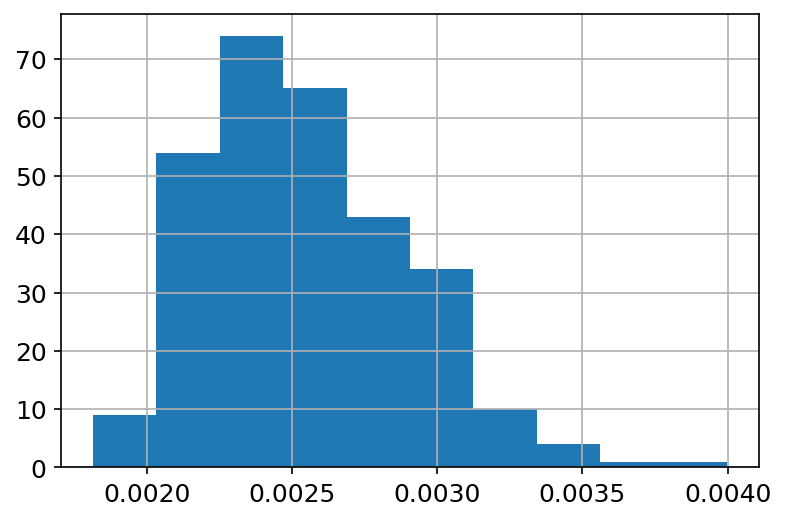

In [37]:
plt.figure(dpi=150)
findable_ele_df.VY.hist()
plt.show()

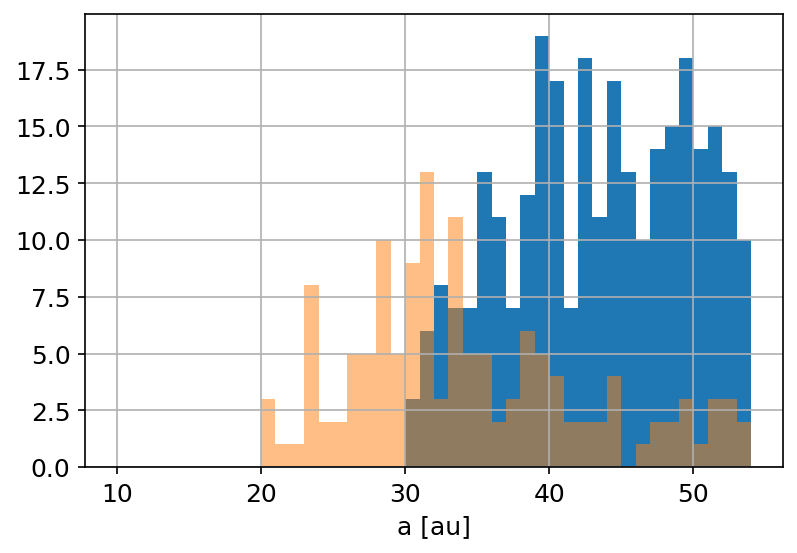

In [41]:
bins=np.arange(10,55)
plt.figure(dpi=150)
findable_ele_df.A.hist(bins=bins)
eledf.a.hist(bins=bins, alpha=0.5)

plt.xlabel('a [au]')
plt.show()

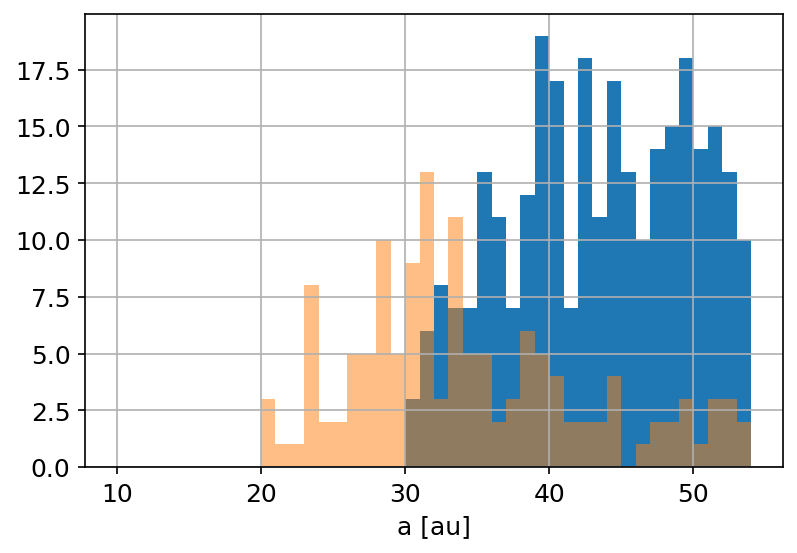

/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/home/eggl/anaconda3/envs/difi_py38/lib/python3.8/site-packages/scipy/stats/stats.py:597: RuntimeWarning: Degrees of freedom <= 0 for slice
  return a.var(ddof=ddof, axis=axis)
/home/eggl/anaconda3/envs/difi_py38/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/eggl/anaconda3/envs/difi_py38/lib/python3.8/site-packages/scipy/stats/stats.py:597: RuntimeWarning: Degrees of freedom <= 0 for slice
  return a.var(ddof=ddof, axis=axis)
/home/eggl/anaconda3/envs/difi_py38/lib/python3.8/s

/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/home/eggl/anaconda3/envs/difi_py38/lib/python3.8/site-packages/scipy/stats/stats.py:597: RuntimeWarning: Degrees of freedom <= 0 for slice
  return a.var(ddof=ddof, axis=axis)
/home/eggl/anaconda3/envs/difi_py38/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/eggl/anaconda3/envs/difi_py38/lib/python3.8/site-packages/scipy/stats/stats.py:597: RuntimeWarning: Degrees of freedom <= 0 for slice
  return a.var(ddof=ddof, axis=axis)
/home/eggl/anaconda3/envs/difi_py38/lib/python3.8/s

In [42]:
bins=np.arange(10,55)
plt.figure(dpi=150)
findable_ele_df.A.hist(bins=bins)
eledf.a.hist(bins=bins, alpha=0.5)

plt.xlabel('a [au]')
plt.show()

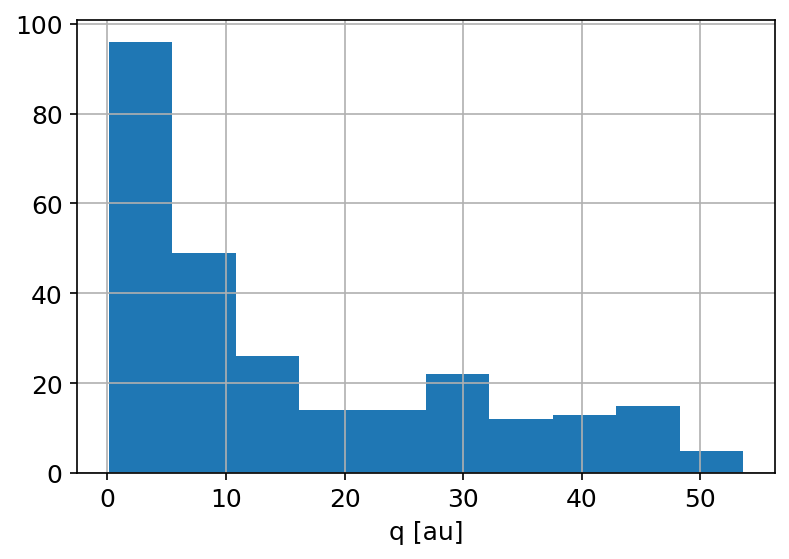

In [40]:
plt.figure(dpi=150)
eledf.q.hist()
plt.xlabel('q [au]')
plt.show()